In [2]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from evalys.jobset import JobSet, ProcSet
from evalys.visu.legacy import plot_gantt

In [5]:
def visualize_avg_waiting_time(jobs_f, sim_f, jobs_e, sim_e):
    fcfs, easy = jobs_f.to_dataframe(), jobs_e.to_dataframe()

    fcfs, easy = JobSet(fcfs), JobSet(easy)

    fcfs, easy = sim_f.to_dataframe(), sim_e.to_dataframe()
    fcfs['name'], easy['name'] = "FCFS", "EASY"
    benchmark = pd.concat([fcfs, easy], ignore_index=True)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Waiting Time")

    plt.subplot(1, 2, 2)
    plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
    plt.grid(axis='y')
    plt.ylabel("Averaged Slowdown")

    plt.show()
    
def visualize_schedule(jobs_easy_batsim, jobs_easy_sp, filepath, max_y):

    _, ax_list = plt.subplots(nrows=2, ncols=1, figsize=(150, 8))
    plot_gantt(jobs_easy_batsim, ax=ax_list[0], title="BATSIM")
    plot_gantt(jobs_easy_sp, ax=ax_list[1], title="SP")

    ax_list[0].set_ylim(0, 16)
    ax_list[1].set_ylim(0, 16)
    ax_list[0].set_xlim(0, max_y)
    ax_list[1].set_xlim(0, max_y)
    ax_list[0].set_yticks(range(16))
    ax_list[1].set_yticks(range(16))

    plt.savefig(filepath)
    plt.show()


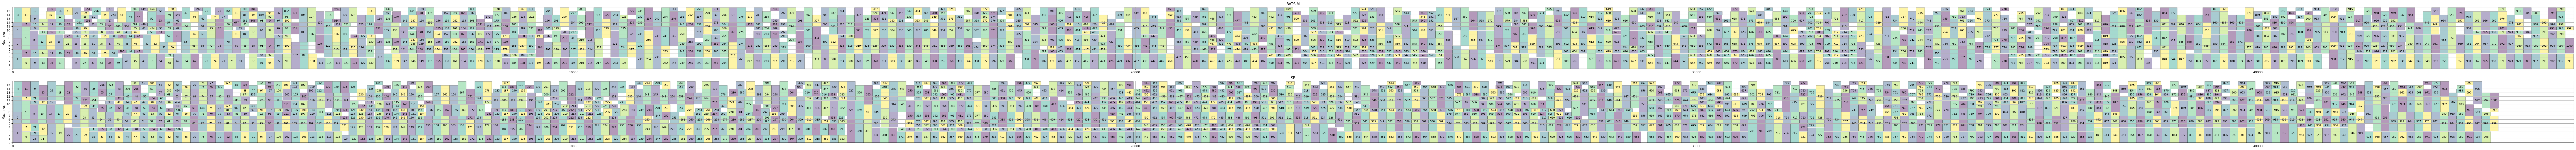

In [6]:
jobs_easy_batsim = pd.read_csv('results/batsim/baseline/easy_jobs_simple_1000_batsched.csv')
jobs_easy_batsim['job_id'] = jobs_easy_batsim['job_id'].astype(str)
jobs_easy_batsim['profile'] = jobs_easy_batsim['profile'].astype(str) 
jobs_easy_batsim = pd.DataFrame(jobs_easy_batsim)
max_jobs_easy_batsim = jobs_easy_batsim['finish_time'].max()
jobs_easy_batsim['allocated_resources'] = jobs_easy_batsim['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_batsim = JobSet(jobs_easy_batsim)

jobs_easy_sp = pd.read_csv('results/cssp/baseline/easy_jobs_simple_1000.csv')
jobs_easy_sp['job_id'] = jobs_easy_sp['job_id'].astype(str)  
jobs_easy_sp['profile'] = jobs_easy_sp['profile'].astype(str)
jobs_easy_sp = pd.DataFrame(jobs_easy_sp)
max_jobs_easy_sp = jobs_easy_sp['finish_time'].max()
jobs_easy_sp['allocated_resources'] = jobs_easy_sp['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_sp = JobSet(jobs_easy_sp)

max_y = max(max_jobs_easy_batsim, max_jobs_easy_sp)

visualize_schedule(jobs_easy_batsim, jobs_easy_sp, 'plt/comparison/easy_baseline_simple_1000.png', max_y)

In [8]:
timeout = 30
jobs_easy_batsim = pd.read_csv(f'results/batsim/timeout/easy_jobs_t{timeout}.csv')
jobs_easy_batsim['job_id'] = jobs_easy_batsim['job_id'].astype(str)
jobs_easy_batsim['profile'] = jobs_easy_batsim['profile'].astype(str) 
jobs_easy_batsim = pd.DataFrame(jobs_easy_batsim)
jobs_easy_batsim['allocated_resources'] = jobs_easy_batsim['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_batsim = JobSet(jobs_easy_batsim)

jobs_easy_sp = pd.read_csv(f'results/cssp/timeout/easy_jobs_t{timeout}.csv')
jobs_easy_sp['job_id'] = jobs_easy_sp['job_id'].astype(str)  
jobs_easy_sp['profile'] = jobs_easy_sp['profile'].astype(str)
jobs_easy_sp = pd.DataFrame(jobs_easy_sp)
jobs_easy_sp['allocated_resources'] = jobs_easy_sp['allocated_resources'].apply(lambda x: ProcSet.from_str(x))
jobs_easy_sp = JobSet(jobs_easy_sp)

visualize_schedule(jobs_easy_batsim, jobs_easy_sp, 'plt/comparison/easy_t30.png')

TypeError: visualize_schedule() missing 1 required positional argument: 'max_y'

In [13]:
# compare jobs monitor SP-Timeout and BATSIM-Timeout
timeout = 30
# jobs_easy_batsim = pd.read_csv(f'results/batsim/timeout/easy_jobs_t{timeout}.csv')
# jobs_easy_sp = pd.read_csv(f'results/cssp/timeout/easy_jobs_t{timeout}.csv')
jobs_easy_batsim = pd.read_csv(f'results/batsim/baseline/easy_jobs_fe_0.csv')
jobs_easy_sp = pd.read_csv(f'results/cssp/baseline/easy_jobs_fe_0.csv')

jobs_easy_batsim = jobs_easy_batsim.sort_values(by='job_id', ascending=True).reset_index(drop=True)
jobs_easy_sp = jobs_easy_sp.sort_values(by='job_id', ascending=True).reset_index(drop=True)

execution_time_diff = jobs_easy_batsim['execution_time'] - jobs_easy_sp['execution_time']
start_time_diff = jobs_easy_batsim['starting_time'] - jobs_easy_sp['starting_time']
finish_time_diff = jobs_easy_batsim['finish_time'] - jobs_easy_sp['finish_time']

def expand_ranges(input_str):
    parts = input_str.split()
    result = []

    for part in parts:
        if '-' in part:
            start, end = map(int, part.split('-'))
            result.extend(str(i) for i in range(start, end + 1))
        else:
            result.append(part)

    result = sorted(result)
    return ' '.join(result)

same_node_used = jobs_easy_batsim['allocated_resources'].apply(expand_ranges) == jobs_easy_sp['allocated_resources'].apply(expand_ranges)

result_df = pd.DataFrame({
    'job_id': jobs_easy_batsim['job_id'],
    'sp_start': jobs_easy_sp['starting_time'],
    'batsim_start': jobs_easy_batsim['starting_time'],
    'sp_finish': jobs_easy_sp['finish_time'],
    'batsim_finish': jobs_easy_batsim['finish_time'],
    'start_diff': start_time_diff,
    'exec_diff': execution_time_diff,
    'finish_diff': finish_time_diff,
    'same_node_used': same_node_used,
    "batsim_node_used": jobs_easy_batsim['allocated_resources'],
    "sp_node_used": jobs_easy_sp['allocated_resources']
})

display(result_df)


,job_id,sp_start,batsim_start,sp_finish,batsim_finish,start_diff,exec_diff,finish_diff,same_node_used,batsim_node_used,sp_node_used
0,1,3.0,3.0,150.0,150.0,0.0,0.0,0.0,True,0-3,0 1 2 3
1,2,6.0,6.0,158.0,158.0,0.0,0.0,0.0,True,4-7,4 5 6 7
2,3,14.0,14.0,162.0,162.0,0.0,0.0,0.0,True,8-12,8 9 10 11 12
3,4,150.0,150.0,298.0,298.0,0.0,0.0,0.0,True,0-3,0 1 2 3
4,5,41.0,41.0,190.0,190.0,0.0,0.0,0.0,True,13-15,13 14 15
...,...,...,...,...,...,...,...,...,...,...,...
995,996,44263.0,44273.0,44412.0,44422.0,10.0,0.0,10.0,True,0-4,0 1 2 3 4
996,997,44270.0,44280.0,44419.0,44429.0,10.0,0.0,10.0,True,7-10 14,7 8 9 10 14
997,998,44410.0,44420.0,44562.0,44572.0,10.0,0.0,10.0,True,5-6 11-13 15,5 6 11 12 13 15
998,999,44419.0,44429.0,44570.0,44580.0,10.0,0.0,10.0,True,0-4 7,0 1 2 3 4 7


In [4]:
# Compare nodes states SP-Timeout and BATSIM-Timeout
import pandas as pd
from IPython.display import display

timeout = 30
jobs_easy_batsim = pd.read_csv(f'results/batsim/timeout/easy_host_t{timeout}.csv')
jobs_easy_sp = pd.read_csv(f'results/cssp/timeout/easy_host_t{timeout}.csv')

jobs_easy_batsim = jobs_easy_batsim.sort_values(by='time', ascending=True).reset_index(drop=True)
jobs_easy_sp = jobs_easy_sp.sort_values(by='time', ascending=True).reset_index(drop=True)

columns_to_compare = ['sleeping', 'switching_on', 'switching_off', 'idle', 'computing']

result_df = pd.DataFrame({
    'time': jobs_easy_batsim['time']
})


for col in columns_to_compare:
    result_df[f'{col}_diff'] = jobs_easy_batsim[f'nb_{col}'] - jobs_easy_sp[col]

display(result_df)

# result_df.to_csv('comparison_result.csv', index=False)


,time,sleeping_diff,switching_on_diff,switching_off_diff,idle_diff,computing_diff
0,0,0,0,0,0,0
1,2,0,0,0,0,0
2,6,0,0,0,0,0
3,30,0,0,0,0,0
4,35,0,0,0,0,0
...,...,...,...,...,...,...
166,4694,0,0,0,0,0
167,4702,0,0,0,0,0
168,4707,0,0,0,0,0
169,4724,0,0,0,0,0


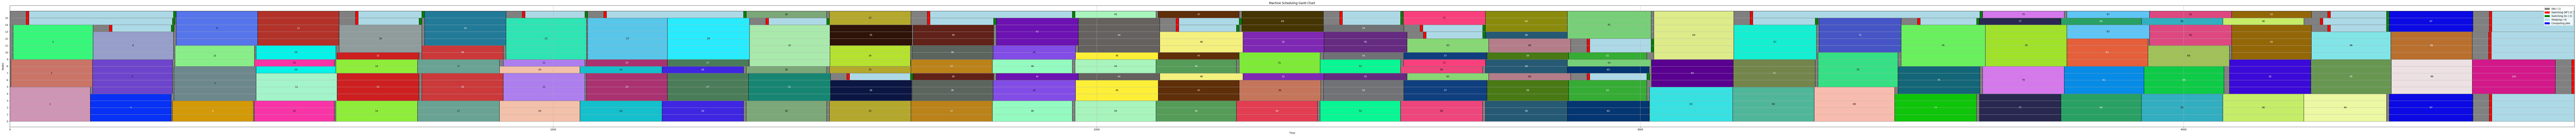

In [1]:
# PLOT SCHEDULE WITHOUT SUBTIME
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

timeout = 30
predict = False
# data = pd.read_csv(f"results/sp/{'tp' if predict else f'timeout'}/easy_nodes_t{timeout}{'_predict' if predict else ''}.csv")
data = pd.read_csv('results/sp/timeout/easy_nodes_t30.csv')
all_nodes = set()
timeline = []

for index, row in data.iterrows():
    nodes = list(map(int, row['allocated_resources'].split())) 
    all_nodes.update(nodes)
    timeline.append({
        'starting_time': float(row['starting_time']), 
        'finish_time': float(row['finish_time']), 
        'allocated_resources': nodes,
        'type': row['type'], 
        'job_id': int(row['job_id'])
    })

fig, ax = plt.subplots(figsize=(150, 8))
max_time = max([ev['finish_time'] for ev in timeline])
max_node = max(all_nodes)

colors = {
    -1: 'gray',      
    -2: 'red',        
    -3: 'green',    
    -4: 'lightblue'    
}

job_colors = {}

for event in timeline:
    nodes = sorted(event['allocated_resources'])
    groups = []
    while nodes:
        start = nodes[0]
        end = start
        while nodes and nodes[0] == end:
            end += 1
            nodes.pop(0)
        groups.append((start, end - start))
    
    for y, height in groups:
        if event['job_id'] in colors:
            color = colors[event['job_id']]
        else:
            if event['job_id'] not in job_colors:
                job_colors[event['job_id']] = np.random.rand(3,)
            color = job_colors[event['job_id']]
        
        ax.broken_barh([(event['starting_time'], event['finish_time'] - event['starting_time'])], 
                      (y, height), facecolors=color, edgecolor='black')
        
        if event['job_id'] > 0:
            ax.text((event['starting_time'] + event['finish_time'])/2, y + height/2, 
                    str(event['job_id']), ha='center', va='center',
                    color='white' if np.mean(color) < 0.5 else 'black')

ax.set_xlabel('Time')
ax.set_ylabel('Nodes')
ax.set_yticks(range(16))
ax.set_yticklabels(range(16))
ax.set_xlim(0, max_time)
ax.grid(True)

legend_patches = [
    mpatches.Patch(color='gray', label='Idle (-1)'),
    mpatches.Patch(color='red', label='Switching Off (-2)'),
    mpatches.Patch(color='green', label='Switching On (-3)'),
    mpatches.Patch(color='lightblue', label='Sleeping (-4)'),
    mpatches.Patch(color='blue', label='Computing Jobs')
]
ax.legend(handles=legend_patches, loc='upper right')

plt.title('Machine Scheduling Gantt Chart')
plt.tight_layout()
# plt.savefig(f"plt/sp/easy_rl.png")
plt.savefig(f"plt/sp/easy_t30.png")
plt.show()

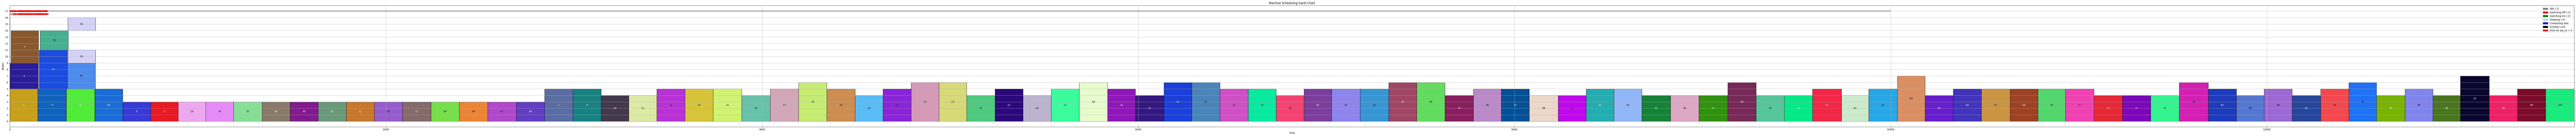

In [24]:
# PLOT SCHEDULE WITH SUBTIME
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

timeout = 30
predict = True
data = pd.read_csv(f"results/sp/{'tp' if predict else f'timeout'}/easy_nodes_t{timeout}{'_predict' if predict else ''}.csv")
# data = pd.read_csv('results/sp/rl/easy_nodes.csv')

all_nodes = set()
timeline = []

for index, row in data.iterrows():
    nodes = list(map(int, row['allocated_resources'].split())) 
    all_nodes.update(nodes)
    timeline.append({
        'submission_time': float(row['submission_time']), 
        'starting_time': float(row['starting_time']), 
        'finish_time': float(row['finish_time']), 
        'allocated_resources': nodes,
        'type': row['type'], 
        'job_id': int(row['job_id']) 
    })

# Create figure
fig, ax = plt.subplots(figsize=(150, 8))
max_time = max([ev['finish_time'] for ev in timeline])
max_node = max(all_nodes)

# Color mapping
colors = {
    -1: 'gray',    
    -2: 'red',        
    -3: 'green',      
    -4: 'lightblue'   
}

job_colors = {}

for event in timeline:
    nodes = sorted(event['allocated_resources'])
    groups = []
    while nodes:
        start = nodes[0]
        end = start
        while nodes and nodes[0] == end:
            end += 1
            nodes.pop(0)
        groups.append((start, end - start))
    
    for y, height in groups:
        if event['job_id'] in colors:
            color = colors[event['job_id']]
        else:
            if event['job_id'] not in job_colors:
                job_colors[event['job_id']] = np.random.rand(3,)
            color = job_colors[event['job_id']]
        
        ax.broken_barh([(event['starting_time'], event['finish_time'] - event['starting_time'])], 
                      (y, height), facecolors=color, edgecolor='black')
        
        if event['job_id'] > 0:
            ax.text((event['starting_time'] + event['finish_time'])/2, y + height/2, 
                    str(event['job_id']), ha='center', va='center',
                    color='white' if np.mean(color) < 0.5 else 'black')

ax.errorbar(x=[5000], y=[17], xerr=5000, fmt='-', color='black')

for event in timeline:
    if event['job_id'] > 0:
        ax.plot(event['submission_time'], 17, 'ro')
        ax.text(event['submission_time'], 16.5, str(event['job_id']), ha='center', va='center', color='red')

ax.set_xlabel('Time')
ax.set_ylabel('Nodes')
ax.set_yticks(range(18))
ax.set_yticklabels(range(18))
ax.set_xlim(0, max_time)
ax.grid(True)

legend_patches = [
    mpatches.Patch(color='gray', label='Idle (-1)'),
    mpatches.Patch(color='red', label='Switching Off (-2)'),
    mpatches.Patch(color='green', label='Switching On (-3)'),
    mpatches.Patch(color='lightblue', label='Sleeping (-4)'),
    mpatches.Patch(color='blue', label='Computing Jobs'),
    mpatches.Patch(color='black', label='Errorbar Line'),
    mpatches.Patch(color='red', label='Dots for job_id > 0')
]
ax.legend(handles=legend_patches, loc='upper right')

plt.title('Machine Scheduling Gantt Chart')
plt.tight_layout()
plt.savefig(f"plt/sp/easy_t{timeout}{'_predict' if predict else ''}.png")
# plt.savefig(f"plt/sp/easy_rl2.png")
plt.show()


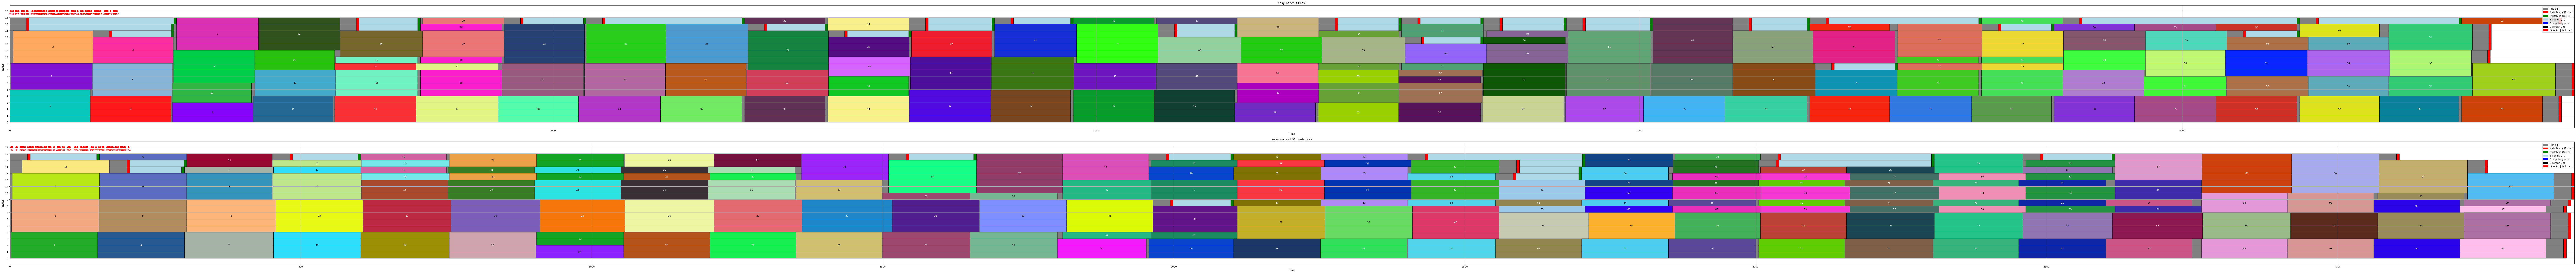

In [2]:
timeout = 30

def parse_data(file_path):
    data = pd.read_csv(file_path)
    all_nodes = set()
    timeline = []

    for index, row in data.iterrows():
        nodes = list(map(int, row['allocated_resources'].split()))  
        all_nodes.update(nodes)
        timeline.append({
            'submission_time': float(row['submission_time']),  
            'starting_time': float(row['starting_time']),  
            'finish_time': float(row['finish_time']),  
            'allocated_resources': nodes,
            'type': row['type'],  
            'job_id': int(row['job_id'])  
        })
    
    return all_nodes, timeline

def plot_timeline(ax, all_nodes, timeline, title):
    max_time = max([ev['finish_time'] for ev in timeline])
    max_node = max(all_nodes)


    colors = {
        -1: 'gray',   
        -2: 'red',      
        -3: 'green',       
        -4: 'lightblue'
    }

    job_colors = {}

    for event in timeline:
        nodes = sorted(event['allocated_resources'])
        groups = []
        while nodes:
            start = nodes[0]
            end = start
            while nodes and nodes[0] == end:
                end += 1
                nodes.pop(0)
            groups.append((start, end - start))
        
        for y, height in groups:
            if event['job_id'] in colors:
                color = colors[event['job_id']]
            else:
                if event['job_id'] not in job_colors:
                    job_colors[event['job_id']] = np.random.rand(3,)
                color = job_colors[event['job_id']]
            
            ax.broken_barh([(event['starting_time'], event['finish_time'] - event['starting_time'])], 
                          (y, height), facecolors=color, edgecolor='black')
            
            if event['job_id'] > 0:
                ax.text((event['starting_time'] + event['finish_time'])/2, y + height/2, 
                        str(event['job_id']), ha='center', va='center',
                        color='white' if np.mean(color) < 0.5 else 'black')

    ax.errorbar(x=[5000], y=[17], xerr=5000, fmt='-', color='black')

    for event in timeline:
        if event['job_id'] > 0:
            ax.plot(event['submission_time'], 17, 'ro')
            ax.text(event['submission_time'], 16.5, str(event['job_id']), ha='center', va='center', color='red')

    ax.set_xlabel('Time')
    ax.set_ylabel('Nodes')
    ax.set_yticks(range(18))
    ax.set_yticklabels(range(18))
    ax.set_xlim(0, max_time)
    ax.grid(True)
    ax.set_title(title)

    legend_patches = [
        mpatches.Patch(color='gray', label='Idle (-1)'),
        mpatches.Patch(color='red', label='Switching Off (-2)'),
        mpatches.Patch(color='green', label='Switching On (-3)'),
        mpatches.Patch(color='lightblue', label='Sleeping (-4)'),
        mpatches.Patch(color='blue', label='Computing Jobs'),
        mpatches.Patch(color='black', label='Errorbar Line'),
        mpatches.Patch(color='red', label='Dots for job_id > 0')
    ]
    ax.legend(handles=legend_patches, loc='upper right')

all_nodes_1, timeline_1 = parse_data(f'results/sp/timeout/easy_nodes_t{timeout}.csv')
all_nodes_2, timeline_2 = parse_data(f'results/sp/tp/easy_nodes_t{timeout}_predict.csv')

fig, axes = plt.subplots(2, 1, figsize=(150, 16))

plot_timeline(axes[0], all_nodes_1, timeline_1, f'easy_nodes_t{timeout}.csv')

plot_timeline(axes[1], all_nodes_2, timeline_2, f'easy_nodes_t{timeout}_predict.csv')

plt.tight_layout()
plt.savefig(f'plt/comparison/tvstp_t{timeout}.png')
plt.show()


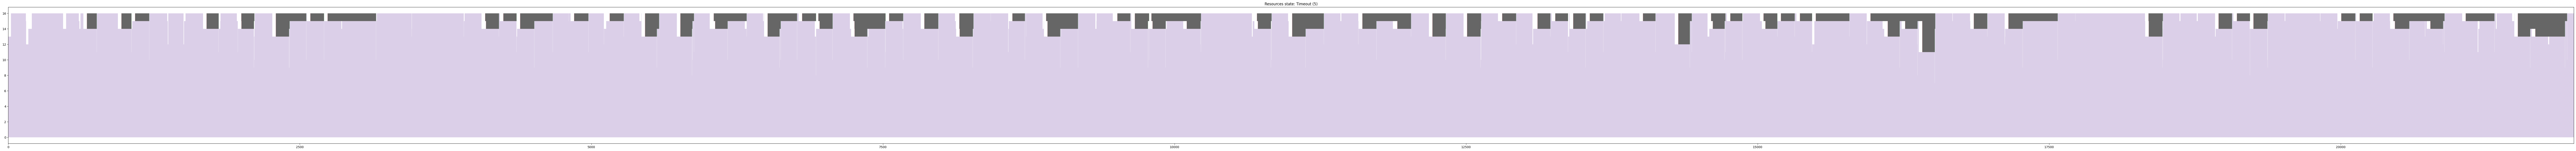

In [ ]:
from evalys.mstates import MachineStatesChanges
from evalys.visu.legacy import plot_mstates

t_5 = pd.read_csv('results/batsim/easy_host_t5.csv')
_, ax_list = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(150, 8))

plot_mstates(t_5, ax=ax_list, title="Resources state: Timeout (5)")


plt.xlim(xmin=0, xmax=22000)
plt.show()